<a href="https://colab.research.google.com/github/ayezabashir/Vision-Transformer-Architecture/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vision Transformer Architecture**

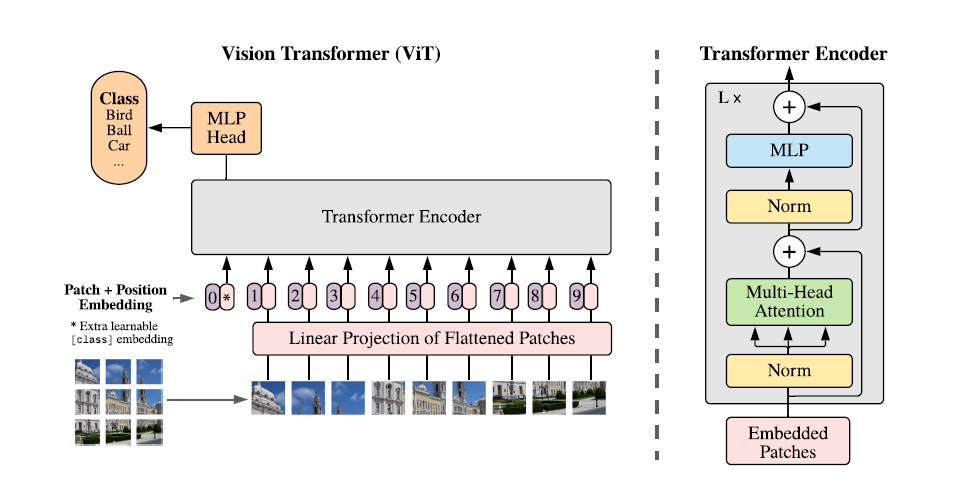

# **Four Equations**

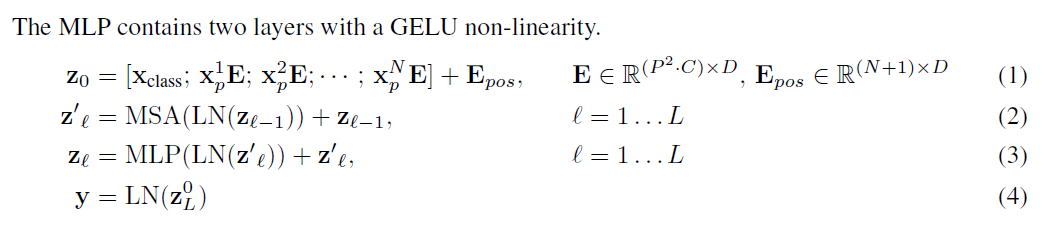

# **Components of Vision Transformer**

### 1-Images to Patches
### 2-Embeddings of Patches
### 3-[class] token
### 4-Positional Encoding
### 5-Self Attention
### 6-Multi Head attention
### 7-Multi Layer Perceptron
### 8-Layer Normalization
### 9-Transformer Encoder
### 10-Classification Head
### 11-Vision Transformer

# **Import Important Libraries**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Image to Patches**

**Training resolution is 224**



In [18]:
image = Image.open('dog.jpg').resize((224,224))
x=np.array(image)
P=16
C=3

# making patches
patches= x.reshape(x.shape[0] // P, P,x.shape[1] // P, P, C ).swapaxes(1,2).reshape(-1,P,P,C)
# flattening the patches
x_p= np.reshape(patches,(-1,P*P*C))
N=x_p.shape[0]


## **2- Embeddings of Patches**

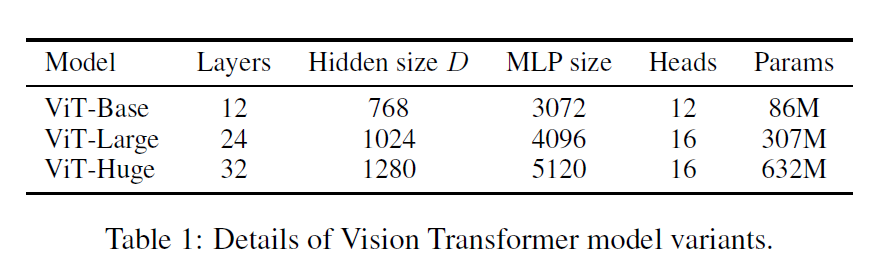

In [19]:
x_p.shape

(196, 768)

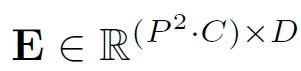

In [20]:
D=768
B=1
x_p=torch.Tensor(x_p)
x_p=x_p[None,...]
E=nn.Parameter(torch.randn(1,P*P*C,D))
patch_embeddings=torch.matmul(x_p,E)
patch_embeddings.shape

torch.Size([1, 196, 768])